# Niche reconstruction and spatial domain detection

Author: Francesca Drummer

In [1]:
import squidpy as sq
import scanpy as sc
import graphcompass as gc

from pathlib import Path

/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


When dealing with spatial transcriptomics datasets we might be interested in defining structures in the tissue. Some tissue structures that are interesting are: cell neighborhoods, niches, microenvironments or spatial domains. In literature these terms are sometimes used interchangably but here we will distinguish them using the Nicheformer definition [2]. 

- **Neighborhoods**: Definition only based on computational graph features such as radius or k-hop neighbors. 
- **Cellular niches**: local structure in a tissue, for example, a tumor niche or immune niche, which vary in gene expression and cell type composition
- **Tissue regions or spatial domains**: Spatially  consistent cellular state across a larger-than-a-niche tissue context. Tissue regions are composed of multiple different niches and therefore describe higher-level structures. 

## Dataset

We will use the Xenium AD dataset here. 

In [2]:
PATH = "/Users/francesca.drummer/Documents/1_Projects/ELIXIR 2025/Xenium_mouse_AD"

In [3]:
# load adata
adata = sc.read_h5ad(Path(PATH, 'anndata', 'Xenium_mouse_AD_annotated.h5ad'))
adata

AnnData object with n_obs × n_vars = 350209 × 347
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'condition', 'time', 'batch_key', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_types_colors', 'dea_leiden_res0_25', 'dendrogram_leiden_res0_25', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

## 1. Cell neighborhood detection via graph construction

Spatial transcriptomics data can be represented as graphs with cells as nodes and edges as relations. Depending on the technology (imaging-based or sequencing-based) different assumptions can be made for the graph structure. 

Here we will explore graph construction and cell neighborhood analysis using the squidpy `sq.gr` module on imaging-based data. 

*Information for graph reconstruciton for sequencing-based data can be found [here](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_spatial_neighbors.html).*

First we construct a graph from the ST data based on number of neighbors to include.  

/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:744: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:390: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if key not in adata.obs or not is_categorical_dtype(adata.obs[key]):
/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:472: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/Users/francesca.drummer/miniconda3/envs/spatial/

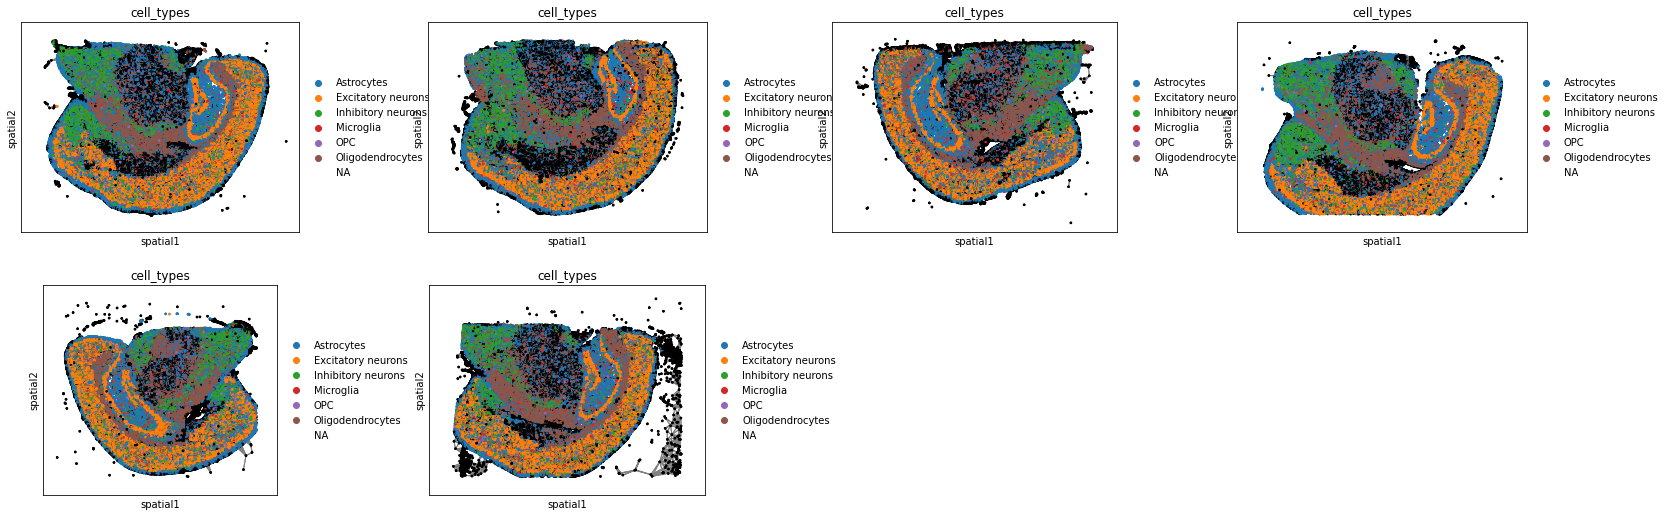

In [28]:
sq.gr.spatial_neighbors(adata, n_neighs=10, coord_type="generic", key_added = 'neighs_based_spatial')
sq.pl.spatial_scatter(
    adata,
    shape=None,
    library_key = 'batch_key',
    color="cell_types",
    connectivity_key="neighs_based_spatial_connectivities",
    size=10,
)

/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:744: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:390: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if key not in adata.obs or not is_categorical_dtype(adata.obs[key]):
/Users/francesca.drummer/miniconda3/envs/spatial/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:472: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/Users/francesca.drummer/miniconda3/envs/spatial/

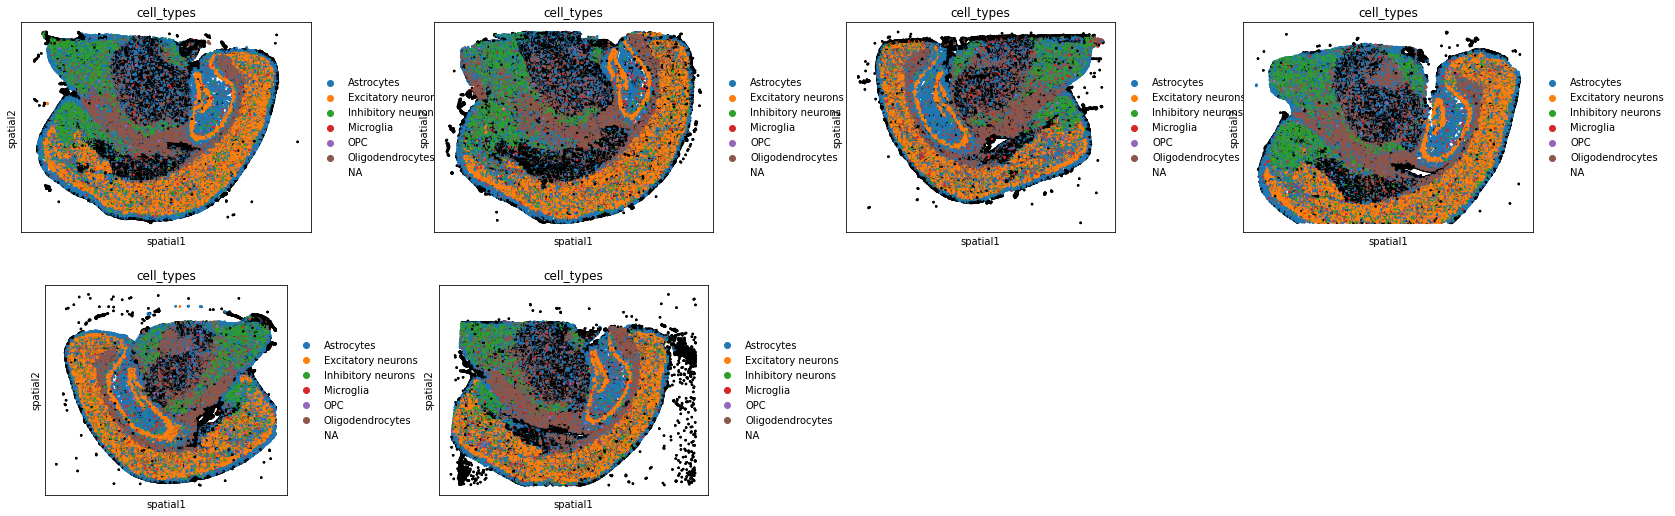

In [30]:
sq.gr.spatial_neighbors(adata, radius=0.3, coord_type="generic", key_added = 'radius_based_spatial')
sq.pl.spatial_scatter(
    adata,
    shape=None,
    library_key = 'batch_key', 
    color="cell_types",
    connectivity_key="radius_based_spatial_connectivities",
    size=10,
)

**Task 1:** What is the difference between the neighborhood and radius based approach? Quantify the difference using the [centrality score](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_centrality_scores.html) and [neighborhood enrichment](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_nhood_enrichment.html). 

### 1.1.  Differential analysis

Once we have a graph construction suitable for the data representation we can perform multiple differential analysis between the different conditions (TgCRND8 vs wildtype). 

GraphCompass [1] introduces analysis methods across conditions. 

GraphCompass Tutorial: https://github.com/theislab/graphcompass/blob/main/notebooks/tutorials/MIBITOF_breast_cancer.ipynb

#### 1.1.1 Comparing entire graphs

GraphCompass introduces two holistic graph comparison metrics:

1. Westfeiler-Lehman Graph Kernels 
2. filtration curves

Both methods compute a graph embedding that can be compared against one another. The graph embeddings are stored in `adata.uns["wl_kernel"]` and `adata.uns["filtration_curves"]` respectively.

In [10]:
if "unknown" not in adata.obs["cell_types"].cat.categories:
    adata.obs["cell_types"] = adata.obs["cell_types"].cat.add_categories("unknown")

adata.obs["cell_types"] = adata.obs["cell_types"].fillna("unknown")

In [ ]:
library_key = "batch_key"
cluster_key = "cell_types"
condition_key = "condition"

#### 1.1.1.1 Westfeiler-Lehman Graph Kernels

In [ ]:
gc.tl.wlkernel.compare_conditions(
   adata=adata,
   library_key=library_key,
   cluster_key=cluster_key,
   compute_spatial_graphs=True,
   kwargs_spatial_neighbors={
        'coord_type': 'generic',
        'delaunay': True,  
  }  
)

Computing spatial graphs...


100%|██████████| 1000/1000 [00:05<00:00, 182.70/s]


Defining node features...


 67%|██████▋   | 4/6 [10:07<05:08, 154.39s/it]

In [ ]:
control_group="normal"  # reference group
metric_key="wasserstein_distance" 
method="wl_kernel"

In [ ]:
gc.pl.wlkernel.compare_conditions(
    adata=adata,
    library_key=library_key,
    condition_key=condition_key,
    control_group=control_group,
    metric_key=metric_key,
    method=method,
    figsize=(3,5),
    dpi=100,
)

#### 1.1.1.2 Filtration curves

#### 1.1.2. Comparing subgraphs

## 2. Cellular niches

In this section, we will analyse and define cellular niches by cell type composition. 

BASNKY

https://github.com/BrainOmicsCourse/BrainOmics2024/tree/main/3_Day3/banksy

## 3. Spatial Domain detection with CellCharter

## References

[1] Ali, M. et al. GraphCompass: Spatial metrics for differential analyses of cell organization across conditions. 2024.02.02.578605 Preprint at https://doi.org/10.1101/2024.02.02.578605 (2024).

[2] Schaar, A. C. et al. Nicheformer: a foundation model for single-cell and spatial omics. 2024.04.15.589472 Preprint at https://doi.org/10.1101/2024.04.15.589472 (2024).

